# Main Process
PSU ID: zvs5275

NAME: Zenan Shi

load necessary modules

load dataset and divide into training and testing

In [1]:
import torch
import numpy as np
import os
import scipy.io
from PIL import Image
from torchvision.transforms import *
from torch.utils.data import DataLoader

def standardize_label(label, orim):
    for idx, _ in enumerate(label):
        labelX = label[idx][0] / orim.size[0]
        labelY = label[idx][1] / orim.size[1]
        label_std.append([labelX, labelY])
    label_std = np.array(label_std)
    # print(label_std)
    return label_std

class PoseImageDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, imagespath='', labelsfilepath=''):

        imgs_list = sorted(os.listdir(os.path.join(imagespath)))
        self.filenames = imgs_list
        self.annotationmat = scipy.io.loadmat(labelsfilepath)
        # print(self.annotationmat) 
        joints = self.annotationmat['joints']
        # print(joints) 
        print(joints.shape) # (3, 14, 2000)
        joints = np.swapaxes(joints, 2, 0)
#         joints = np.swapaxes(joints, 2, 1) # used in lspet
        print(joints.shape)

        labels = []
        images = []
        origin_image_size = []

        for file_idx, file_name in enumerate(imgs_list):
            fn = imgs_list[file_idx]
            orim = Image.open(os.path.join(imagespath,fn))
            origin_image_size.append(orim.size)
            # print(orim)   
            # print(self.transforms)
            image1 = transforms(orim)  
            # print(image1.shape)
            label = joints[file_idx]
            # print(label)
            #standardizing标准化
            label = standardize_label(label, orim)
            # print(label)
            label = torch.from_numpy(label)  
            label1 = label.type(torch.FloatTensor)
            images.append(image1)
            labels.append(label1)
#             print(label1)
#             break
            
        self.images = images
        self.labels = labels
        self.orim_size = origin_image_size
        

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.orim_size[idx]

    def __len__(self):
        return len(self.filenames)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"using {device}")

image_path = './dataset/lsp/images'
labels_file_path = './dataset/lsp/joints.mat'
# image_path = './dataset/lspet/images'
# labels_file_path = './dataset/lspet/joints.mat'
# image_size = 128
# image_size = 256 # blazepose
image_size = 196 # Alex
batch_size = 32
transforms = Compose([
    Resize((image_size,image_size)),
    ToTensor(),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


dataset = PoseImageDataset(transforms, image_path, labels_file_path)
# print(dataset.images.shape)  #(2000, 14, 3)


total = len(dataset)
print(total)
train_size = int(total * 0.5)
test_size = total - train_size
lengths = [train_size, test_size]
train_dataset, test_dataset = torch.utils.data.dataset.random_split(dataset, lengths)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

using cuda
(3, 14, 2000)
(2000, 14, 3)
2000


### visualiazation of dataset

3
tensor([[0.6457, 0.5403],
        [0.6196, 0.5931],
        [0.5813, 0.5244],
        [0.5506, 0.5105],
        [0.5414, 0.5519],
        [0.4800, 0.5838],
        [0.5352, 0.6274],
        [0.4479, 0.6045],
        [0.4555, 0.5426],
        [0.5107, 0.4555],
        [0.4479, 0.3959],
        [0.4111, 0.3684],
        [0.3144, 0.2927],
        [0.4831, 0.3569]])
torch.Size([14, 2])
tensor([0.6457, 0.5403])
[126.564926 121.43681  113.929886 107.92434  106.11097   94.08038
 104.90206   87.78236   89.283745 100.10542   87.78236   80.56791
  61.61534   94.68484 ]
[105.89206  116.23936  102.77331  100.06261  108.16555  114.43222
 122.972374 118.483696 106.35843   89.27812   77.59006   72.19781
  57.361843  69.95347 ]


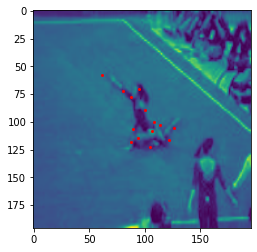

In [23]:
import matplotlib.pyplot as plt

dataiter = iter(train_dataloader)
print(len(dataiter.next()))
images, labels, int_labels= dataiter.next()
img = images[0]
img = img.numpy()
img = np.transpose(img, (1, 2, 0))
img = img[:,:,-1::]
# plt.imshow(img)
plt.figure()
print(labels[0])
print(labels[0].shape)
print(labels[0][0])
x = [labels[0][i][0] * image_size for i in range(14)]
y = [labels[0][i][1] * image_size for i in range(14)]
print(np.array(x))
print(np.array(y))
plt.scatter(np.array(x), np.array(y), color = 'red', s = 4)
# print(len(int_labels[0]))
plt.imshow(img)

## model based on AlexNet

In [17]:
import torch
import torch.nn as nn

class AlexNetPose(nn.Module):
    def __init__(self):
        super(AlexNetPose, self).__init__()

        self.model = torch.nn.Sequential(

        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=2, alpha=2e-05, beta=0.75, k=1),  #局部响应归一化层
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=0),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=2, alpha=2e-05, beta=0.75, k=1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=0),

        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=0),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=0),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Flatten(),
        nn.Linear(in_features=256, out_features=4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.6),

        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.6),
        nn.Linear(in_features=4096, out_features=28)
        )


    def forward(self, input):
        endOut = self.model(input)
        return endOut
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetPose().to(device)
# model = torch.load("AlexNetPose.model").to(device)
print(model)

AlexNetPose(
  (model): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(2, alpha=2e-05, beta=0.75, k=1)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(2, alpha=2e-05, beta=0.75, k=1)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=256, out_features=4096, bias=True)
    (17): ReLU(inplace=True)
    (18): 

## transfer learning using ResNet

In [57]:
import torch
import torch.nn as nn
import torchvision
# 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'
resnet = torchvision.models.resnet34(pretrained=True)
in_features = resnet.fc.in_features
resnet.fc = nn.Sequential(nn.Linear(in_features, 28))
model = resnet.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
import torch
import torch.nn as nn
import torchvision

model = torch.load("ResNet34.model").to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## training and testing function

In [2]:
def train():
#     model.train()
    loss_value = 0
    for tmp, (images, labels, _) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        predict = model(images)
        predict = predict.view(labels.shape)
        loss_value = lossFunction(predict, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        if tmp > 0:
            if (tmp % 10) == 0:
                torch.save(model.state_dict(), './model_checkpoint.chp')

    return loss_value.item()

def test():
#     model.eval()
    test_loss_total = 0

    images_accuracy = []
    
    with torch.no_grad():
        for images, labels, orim_size in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            predict = model(images)

            predict = predict.view(labels.shape)

            for idx, _ in enumerate(labels):
                image_accuracy = accuracy_compute(predict[idx], labels[idx], image_size)
                images_accuracy.append(image_accuracy)

            loss_value = lossFunction(predict, labels)

            test_loss_total += loss_value


        accuracy = sum(images_accuracy) / len(images_accuracy)
        test_loss_total /= len(test_dataset)

#         print("accuracy：", accuracy)
        return test_loss_total, accuracy


def accuracy_compute(predict, labels, img_size, deviation_distance = 10):
    joints = 14
    correct = 0

    for idx, _ in enumerate(labels):
        # print(predict[idx] * img_size, labels[idx] * img_size)
        deviation = ((predict[idx] - labels[idx]) * img_size) ** 2
        deviation = sum(deviation)
        # print(deviation)
        # print(deviation_distance ** 2)

        if deviation <= deviation_distance ** 2:
            correct += 1

    accuary = correct / joints

    return accuary

## the main training process

In [10]:
test_loss, accuracy = [], []

lossFunction = torch.nn.MSELoss(reduction='sum')  # mean square error
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)  # learning rate0.00001

EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    train_loss = train()
    test_loss_, accuracy_ = test()
    print(f"the {epoch}/{EPOCHS} epoch，training loss is {train_loss}, testing loss is {test_loss_}, testing accuracy is {accuracy_}")

    test_loss1 = test_loss_.detach().cpu().numpy()
    test_loss.append(test_loss1)
    accuracy.append(accuracy_)

# model_name = "AlexNetPose"
# torch.save(model, model_name + ".model")

第1/1次训练，训练损失值为0.9324826002120972, 测试损失值为0.1725536435842514,测试准确率为0.5838571428571423


In [1]:
model_name = "AlexNetPose"
torch.save(model, model_name + ".model")

NameError: name 'torch' is not defined

In [9]:
import torch
import torch.nn as nn

model = torch.load("ResNet50.model.196").to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## result visualization

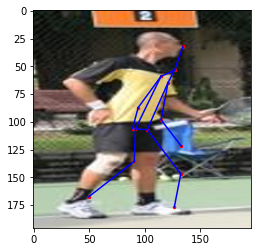

In [15]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os
from PIL import Image
from torchvision.transforms import *
import numpy as np


transforms = Compose([
    Resize((image_size,image_size)),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
image_path = './dataset/lsp/images'
sample_idx = 1879
image_size = 196

imgs_list = os.listdir(os.path.join(image_path))
orim = Image.open(os.path.join(image_path, imgs_list[sample_idx - 1]))

image1 = transforms(orim)
image1 = Variable(torch.unsqueeze(image1, dim=0).float(), requires_grad=False)

image = image1.to(device)
predict = model(image)
# print(predict)
predict_ = predict.view((14, 2)).cpu().detach().numpy()
# print(predict_)
plt.figure()
for j in ((13, 12), (12, 8), (12, 9), (8, 7), (7, 6), (9, 10), (10, 11), (2, 3), (2, 1), (1, 0), (3, 4), (4, 5), (2, 8), (3, 9)):
    plt.plot([predict_[j[0]][0] * image_size, predict_[j[1]][0] * image_size], [predict_[j[0]][1] * image_size, predict_[j[1]][1] * image_size], color='b')

x = [predict_[i][0] * image_size for i in range(14)]
y = [predict_[i][1] * image_size for i in range(14)]
plt.scatter(np.array(x), np.array(y), color = 'red', s = 6)

# img = np.transpose(orim, (1, 2, 0))
# img = img[:,:,-1::]
plt.imshow(orim.resize((image_size, image_size)))
